<a href="https://colab.research.google.com/github/wonseokb/Genat4_Study/blob/main/NeuralNetwork_ipynb(HW)_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/UT-GEOML/GEO391/blob/main/6-NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Networks

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Single-layer_feedforward_artificial_neural_network.png/800px-Single-layer_feedforward_artificial_neural_network.png)
https://en.wikipedia.org/wiki/Artificial_neural_network

In a previous assignment, we met our first toy neural network. Here, we will adopt the neural network approach to analyze seismic data using manual interpretation as guidance.

## Data Loading

Let us start by loading seismic data and a picked horizon. For simplicity, we will start with the sea floor.

In [1]:
!pip install segpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 5.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=2a5e0e4b46720b436b12ec0527a6cfce52339521051b5cfd966596e6be9f03a3
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

!wget url_to_file # to download a file to the current server that you are running the notebook on

!unzip filename # unzip the zip file (if necessary)

Mounted at /content/drive
--2023-02-26 23:35:45--  http://url_to_file/
Resolving url_to_file (url_to_file)... failed: Name or service not known.
wget: unable to resolve host address ‘url_to_file’
unzip:  cannot find or open filename, filename.zip or filename.ZIP.


In [3]:
import os
from segpy.reader import create_reader

# this file is available from: https://www.dropbox.com/s/680edyveewojcxn/class2021_16_bit.sgy

# from google.colab import drive
# drive.mount('/content/gdrive')
# change the directory name below to your local path
# dirname = '/content/gdrive/MyDrive'
dirname = '/content/drive/My Drive/' # change path to your local path, of course
filename = 'class2021_16_bit.sgy'

#dirname = '/users/sergey/Downloads'
# Seismic data resampled to 16-bit SEGY format
#filename = 'class2021_16_bit.sgy'
segy = open(os.path.join(dirname, filename), 'rb')
reader = create_reader(segy)
print(reader.num_traces())  # check number of traces

INFO:segpy.reader:Successfully unpickled reader for /content/drive/My Drive/class2021_16_bit.sgy


697761


The code above should output <code>697761</code>. 

In [4]:
import numpy as np

# get cube dimensions
nt = reader.max_num_trace_samples()  # samples in a trace
n_inlines = reader.num_inlines()  # number of inlines
n_xlines = reader.num_xlines()  # number of crosslines
print(nt, n_inlines, n_xlines)


def read_slice(inline):
    'read one inline slice'
    section = np.zeros((nt, n_xlines))
    for i in range(n_xlines):
        section[:, i] = reader.trace_samples(inline*n_xlines + i)
    return section

2001 1161 601


The seismic cube size in (time,inline,crossline) coordinates is (2001,1161,601). Let us display one inline section.

In [5]:
import matplotlib.pyplot as plt

dt = 0.004  # time sampling in seconds
dx = 0.025  # trace sampling in kilometers


def plot_seismic(section):
    plt.imshow(section, cmap='gray', vmin=-2000, vmax=2000, aspect=0.5)
    yticks = np.arange(0, section.shape[0], 250)
    ytick_labels = [str(dt*k) for k in yticks]
    plt.yticks(ticks=yticks, labels=ytick_labels)
    plt.ylabel('two-way traveltime (s)', fontsize=14)
    xticks = np.arange(0, section.shape[1], 100)
    xtick_labels = [str(dx*k) for k in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.xlabel('distance (km)', fontsize=14)

Next, let us load and display the seafloor horizon.

In [6]:
import pandas as pd

url = 'https://raw.githubusercontent.com/zsylvester/GEO391_materials/master/FE_horizons/seafloor_XY_il_cl.csv'

df = pd.read_csv(url, names=['x', 'y', 'il', 'xl', 'z'])
df.tail()

,x,y,il,xl,z
697693,405251.32,3234671.92,2030,7066,400.316566
697694,405269.58,3234689.00,2030,7067,399.911404
697695,405287.83,3234706.09,2030,7068,399.521232
697696,405306.09,3234723.17,2030,7069,399.086058
697697,405324.34,3234740.25,2030,7070,398.660868


In [7]:
min_il = df['il'].min()  # minimum inline number
max_il = df['il'].max()  # maximum inline number

min_xl = df['xl'].min()  # minimum crossline number
max_xl = df['xl'].max()  # maximum crossline number

# load horizon in a 2D numpy array
z = np.zeros((n_inlines, n_xlines))

il_ind = df['il'][:] - min_il
xl_ind = df['xl'][:] - min_xl
z[il_ind, xl_ind] = df['z'][:]

In [8]:
# fill in the surface where there is no valid data:
zero_row, zero_col = np.where(z == 0)  # find locations where z = 0
for i in range(len(zero_row)):
    patch = z[zero_row[i] - 2: zero_row[i] + 3, zero_col[i] -
              2: zero_col[i] + 3]  # patch of 5x5 pixels
    # take the mean of nonzero neighbors
    z[zero_row[i], zero_col[i]] = np.mean(patch[patch != 0])

To verify the horizon pick, let us display it on top of
a seismic section.

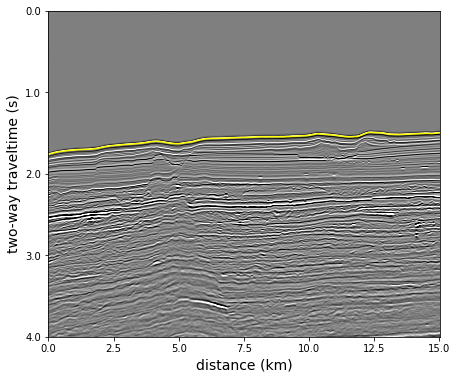

In [9]:
def plot_section(iline):
    section = read_slice(iline)[:1001]  # window top half
    seafloor = z[iline, :]
    plt.figure(figsize=(15, 6))
    plot_seismic(section)
    plt.plot(seafloor/(dt*1000), color='yellow')
    plt.show()


plot_section(500)

## Extracting Seismic Wavelets

Our goal is to teach the computer to pick a horizon automatically. To do that, we are going to extract seismic wavelets centered at the seafloor and compare them with wavelets from elsewhere in the section.

In [10]:
# select one 2D section
section = read_slice(500)
seafloor = z[500, :]

nw = 21  # set wavelet length ##Task1-1-1

sf_wavelets = []
ntraces = len(seafloor)
for k in range(ntraces):
    trace = section[:, k]
    # convert miliseconds to index
    center = int(np.rint(seafloor[k]/(dt*1000)))
    # extract wavelet centered at seafloor
    wavelet = trace[center-nw//2:center+nw//2+1]
    sf_wavelets.append(wavelet)

Let us plot some seafloor wavelets to observe their shape.

In [11]:
def plot_wavelets(wavelets, traces, title):
    nw = len(wavelets[0])
    ncols = len(traces)
    f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))
    twt = np.arange(-nw//2+1, nw//2+1)*dt
    for trace in range(ncols):
        axt = ax[trace]
        # plot as curve
        amp = wavelets[traces[trace]]
        axt.plot(amp, twt, 'k')
        axt.set_ylim(twt.max(), twt.min())
        if trace == 0:
            axt.set_ylabel('Time (s)')
        else:
            axt.set_yticklabels([])
        axt.set_xticks([])
    f.suptitle(title, fontsize=25)
    plt.show()

To train our model, we will also randomly extract wavelets from elsewhere in the section. For proper training, we will extract 10 times more other wavelets.

In [12]:
import random
random.seed(2023)

wavelets = []
cases = 10
for k in range(ntraces):
    trace = section[:,k]
    sf=int(np.rint(seafloor[k]/(dt*1000)))
    for case in range(cases):
        # select center randomly
        center=random.randint(nw,nt-nw)
        # make sure it is not at the seafloor
        while center==sf:
            center=random.randint(nw,nt-nw)
        # extract wavelet
        wavelet=trace[center-nw//2:center+nw//2+1]
        wavelets.append(wavelet)

A human can be easily trained to dinstinguish between seafloor and non-seafloor wavelets. To teach the computer to do that, we will build a model using neural networks.

## Python Packages for Deep Learning

As we saw previously, a simple neural network can be built using <code>MLPClassifier</code> from <code>sklearn</code> package. Several alternative open-source packages exist for more advanced methods and architectures.

In [13]:
!pip install pytrends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will be using **Keras** in today's example.

## Designing a Neural Network

Let us first collect data from seafloor and non-seafloor wavelets.

In [14]:
random.seed(2023)

all_wavelets = sf_wavelets+wavelets
random.shuffle(all_wavelets)
data = np.array(all_wavelets)
data.shape

(6611, 21)

In [15]:
# normalize data
scale = 1.0/5000  #Task1-1-2
data = data*scale

For training, we will label seafloor wavelets as 1 and non-seafloor wavelets as 0. 

In [16]:
random.seed(2023)

indicators = [1]*len(sf_wavelets)+[0]*len(wavelets)
random.shuffle(indicators)
labels = np.array(indicators)
labels.shape

(6611,)

Our network will contain one hidden layer, which will transfer its output to classification.

In [17]:
from tensorflow import keras
import tensorflow.random

# for reproducibility
tensorflow.random.set_seed(2023)
np.random.seed(2023)

model = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

To train the model, we will ask it to use the Adam optimizer and the cross-entropy loss function. We will also ask it to track the prediction accuracy (the percentage of accurate preductions).

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Training the Model

Because we have only few seafloor wavelets compared to the number of other wavelets, we would need to scale them differently to avoid bias. 

In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',classes=[0,1],
                               y=labels)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.55, 1: 5.5}


Finally, we are ready to train the model. Note that Keras handles splitting the data into training and validation internally during training.

In [20]:
# fit the model
batch_size=10
epochs=15
fit = model.fit(data,labels,
                batch_size=batch_size,
                epochs=epochs,
                class_weight=class_weights,
                validation_split=0.3)

Epoch 1/15
463/463 [==============================] - 2s 2ms/step - loss: 0.4513 - accuracy: 0.9695 - val_loss: 0.2010 - val_accuracy: 0.9914
Epoch 2/15
463/463 [==============================] - 1s 2ms/step - loss: 0.1193 - accuracy: 0.9946 - val_loss: 0.0518 - val_accuracy: 0.9960
Epoch 3/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0386 - accuracy: 0.9965 - val_loss: 0.0259 - val_accuracy: 0.9960
Epoch 4/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0193 - accuracy: 0.9972 - val_loss: 0.0178 - val_accuracy: 0.9965
Epoch 5/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0123 - accuracy: 0.9976 - val_loss: 0.0151 - val_accuracy: 0.9960
Epoch 6/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.0133 - val_accuracy: 0.9970
Epoch 7/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.0134 - val_accuracy: 0.9970
Epoch 

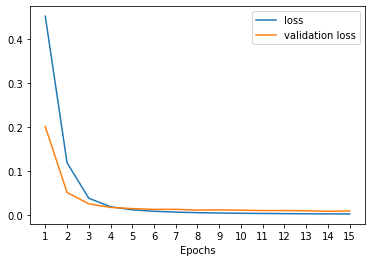

In [21]:
def plot_loss(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

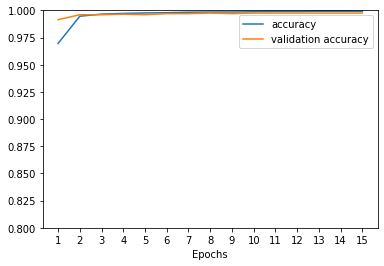

In [22]:
def plot_accuracy(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['accuracy'], label='accuracy')
    plt.plot(iterations, fit.history['val_accuracy'],
             label='validation accuracy')
    plt.legend()
    plt.ylim(0.8, 1.0)
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_accuracy(fit, epochs)

As we expect, the loss goes down, and the accuracy goes up with iterations. 

The fact that training is more accurate than validation might indicate the problem of *overfitting*, which happens when the model is tuned too much to match training data, while failing to pick a more general pattern.

## Overcoming Overfitting: Dropout

A simple way to address the overfitting problem is *dropout*: randomly dropping out a portion of "neurons" during the training process. 

* Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I. and Salakhutdinov, R., 2014. [Dropout: a simple way to prevent neural networks from overfitting](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). The Journal of Machine Learning Research, 15(1), pp.1929-1958.

Let us redefine our model to include a dropout layer.

In [23]:
drop = 0.1  # drop out 10% of neurons

model2 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dropout(drop),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

In [24]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 176       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile(loss='binary_crossentropy',
               optimizer='adam', 
               metrics=['accuracy'])

In [26]:
# fit the model
batch_size=10
epochs=15
fit2 = model2.fit(data,labels,
                  batch_size=batch_size,
                  epochs=epochs,
                  class_weight=class_weights,
                  validation_split=0.3)

Epoch 1/15
463/463 [==============================] - 2s 2ms/step - loss: 0.4984 - accuracy: 0.8409 - val_loss: 0.3407 - val_accuracy: 0.9688
Epoch 2/15
463/463 [==============================] - 1s 2ms/step - loss: 0.1542 - accuracy: 0.9771 - val_loss: 0.1038 - val_accuracy: 0.9884
Epoch 3/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0598 - accuracy: 0.9892 - val_loss: 0.0489 - val_accuracy: 0.9914
Epoch 4/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0356 - accuracy: 0.9918 - val_loss: 0.0299 - val_accuracy: 0.9934
Epoch 5/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0250 - accuracy: 0.9933 - val_loss: 0.0233 - val_accuracy: 0.9945
Epoch 6/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0192 - accuracy: 0.9955 - val_loss: 0.0194 - val_accuracy: 0.9950
Epoch 7/15
463/463 [==============================] - 1s 2ms/step - loss: 0.0150 - accuracy: 0.9963 - val_loss: 0.0170 - val_accuracy: 0.9950
Epoch 

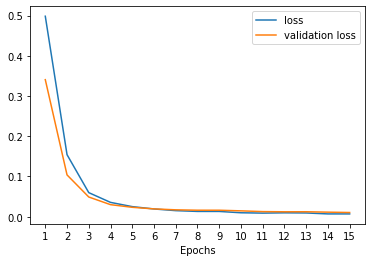

In [27]:
plot_loss(fit2,epochs)

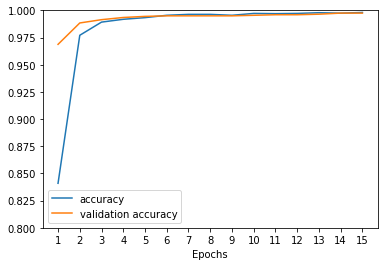

In [28]:
plot_accuracy(fit2,epochs)

## Checking Prediction Accuracy

In [29]:
# predicting probabilities
pred = model2.predict(data)
print(pred)

207/207 [==============================] - 0s 956us/step
[[3.5382618e-07]
 [4.4811779e-05]
 [2.1431966e-05]
 ...
 [2.4634932e-05]
 [2.5804850e-04]
 [9.3996105e-06]]


Let us find examples of mis-identified wavelets.

In [30]:
false = np.nonzero(np.rint(pred[:,0]) != labels)
print(false)

(array([1909, 2960, 3306, 3338, 3551, 4370, 5047, 5467, 5809, 6091, 6312]),)


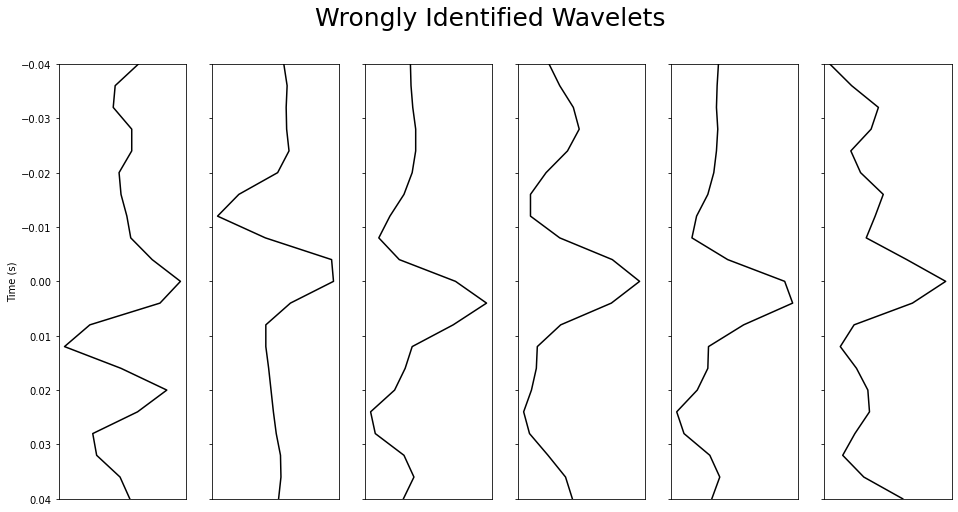

In [31]:
plot_wavelets(list(data),false[0][1:7],
             'Wrongly Identified Wavelets')

In [32]:
pred[false[0][1:7]]

array([[0.5651228],
       [0.9991801],
       [0.9781659],
       [0.8611992],
       [0.9967879],
       [0.5276418]], dtype=float32)

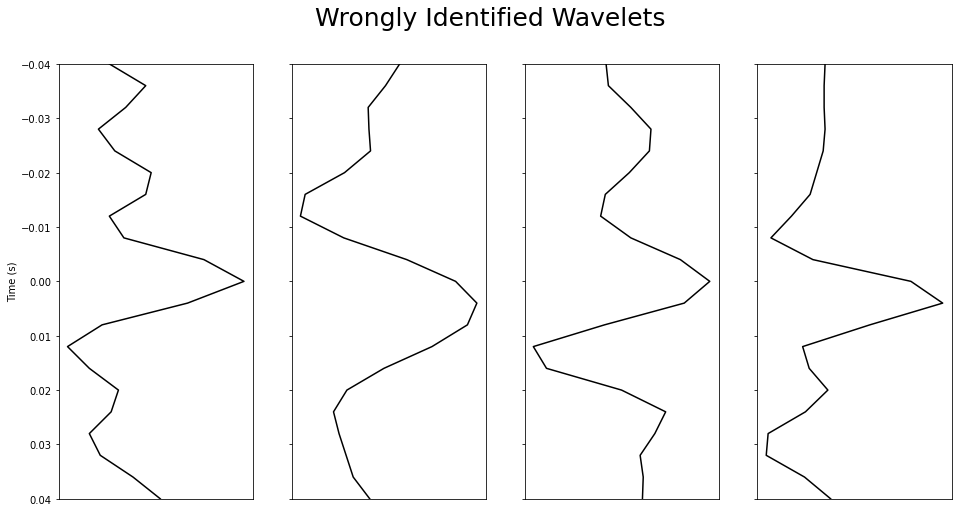

In [33]:
plot_wavelets(list(data),false[0][7:13],
             'Wrongly Identified Wavelets')

In [34]:
pred[false[0][7:13]]

array([[0.6622434],
       [0.9999904],
       [0.7998674],
       [0.943772 ]], dtype=float32)

## Checking Model Parameters

To try to understand the internal structure of the neural network, we can also display model parameters.

In the hidden layer, the main parameters are contained in the $\mathbf{B}_1$ matrix:

$$y = s\left(a_2 + \mathbf{b}_2^{T}\,r\left(\mathbf{a}_1 + \mathbf{B}_1^{T}\,\mathbf{x}\right)\right)\;.$$

In [35]:
weights,intercepts = model2.layers[0].get_weights()
len(weights)

21

In [36]:
weights=np.array(weights)
weights.shape

(21, 8)

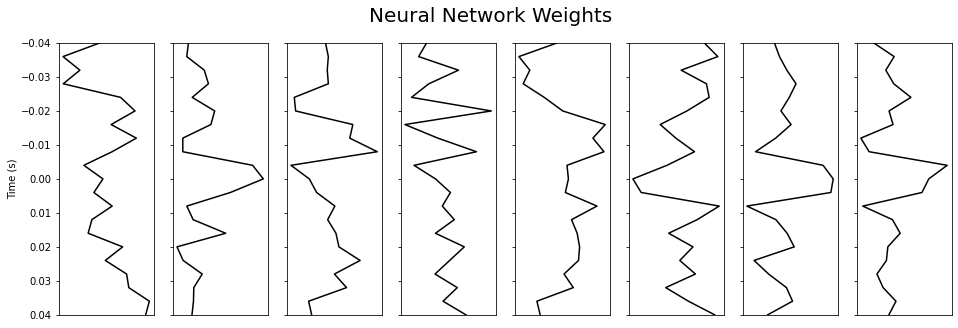

In [37]:
f, ax = plt.subplots(nrows=1,ncols=8,figsize=(16,5))
twt = np.arange(-nw//2+1,nw//2+1)*dt
for trace in range(8):
    axt = ax[trace]
    # plot as curve
    amp=weights[:,trace]
    axt.plot(amp,twt,'k')
    axt.set_ylim(twt.max(),twt.min())
    if trace == 0:
        axt.set_ylabel('Time (s)')
    else:
        axt.set_yticklabels([])
    axt.set_xticks([])
f.suptitle('Neural Network Weights',fontsize=20)
plt.show()

## Application to Seafloor Picking

We trained our model on one section out of the 3D seismic cube. We can now try to apply it on other sections for automatic picking of the seafloor horizon.

In [38]:
from scipy.signal import find_peaks

section = read_slice(700)[:1001, :]

pick = np.zeros(ntraces)
for k in range(ntraces):
    trace = section[:, k]
    # find local maxima
    peaks, _ = find_peaks(np.abs(trace))
    test_wavelets = []
    for peak in peaks:
        if peak > nw and peak < 1001-nw:
            wavelet = trace[peak-nw//2:peak+nw//2+1]
            test_wavelets.append(wavelet)
    # normalize
    test_wavelets = np.array(test_wavelets)*scale
    # get probabilities
    pred = model2.predict(test_wavelets)
    # select the highest probability
    best = np.argmax(pred)
    pick[k] = peaks[best]

6/6 [==============================] - 0s 1ms/step


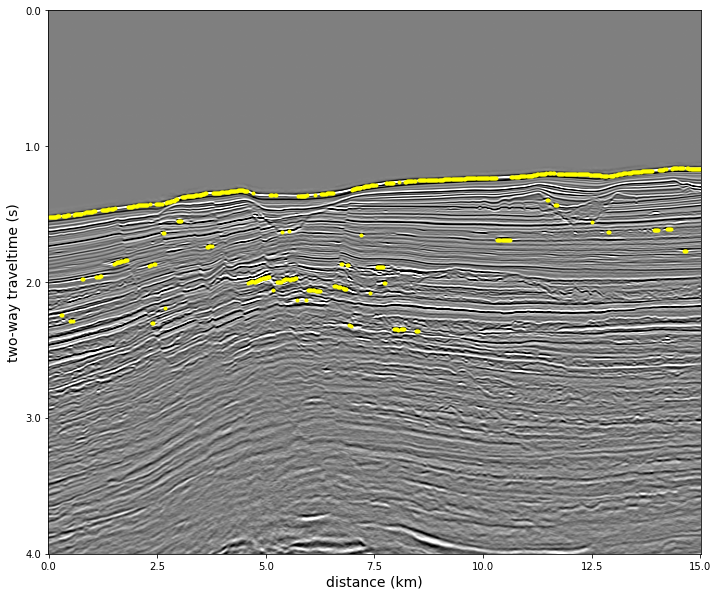

In [39]:
plt.figure(figsize=(15, 10))
plot_seismic(section)
plt.plot(pick, color='yellow', marker='.', linestyle='None')
plt.show()

## <span style="color:red">Task 1</span>

There are several ways to improve the results.

1. Use better training data.

For example:

- Find the parameter responsible for the length of the wavelet. Does it help to increase it from 21 to 41?
- Find the parameter responsible for scaling the wavelet amplitude. Does it help to change it from 1/5000 to a different number?

2. Use more training data.

For example:

- Generate more cases of non-seafloor wavelets by increasing the parameter called <code>cases</code>.
- Collect seafloor and non-seafloor wavelets for training from more than one section.

3. Change the model definition.

For example:

- Does it help to change the size of the output in the hidden layer? Should it be increased or decreased?
- Does it help to add more layers to the network?

<div class="alert alert-info">
Note that you can save a previously generated and trained model in a file using
    
<code>keras.models.save_model(model, 'model.h5', save_format='h5')</code>
    
The file format in this case is HDF-5 (Hierarchical Data Format).
    
Load the model back with
    
<code>model = keras.models.load_model('model.h5')</code>
    
Reset Keras memory for generating and training a new model using

<code>keras.backend.clear_session()</code>
</div>    

4. Change optimization parameters.

For example:

- Does it help to change the learning rate in Adam optimizer?
- Does it help to change the batch size?

The list of **Keras** optimizers and their parameters is available at https://keras.io/api/optimizers/

In [40]:
keras.optimizers.Adam?

![](https://i.stack.imgur.com/3vZUJ.png)

* Kingma, D.P. and Ba, J., 2014. Adam: A method for stochastic optimization. arXiv preprint [arXiv:1412.6980](https://arxiv.org/abs/1412.6980).

<span style="color:red">Out of this long list of possibilities, pick two from two different categories and try them out.</span>

## <span style="color:red">Task 2</span>

Another way to improve the results is to change the formulation of the problem. For example, instead of classifying all wavelets into only two classes (seafloor and non-seafloor), we can increase the number of classes and try, for example, three classes: water, seafloor, and sediments below the seafloor.

In [41]:
section = read_slice(500)
seafloor = z[500, :]

w_wavelets = []
s_wavelets = []

cases = 40

for k in range(ntraces):
    trace = section[:, k]
    # convert miliseconds to index
    sf = int(np.rint(seafloor[k]/(dt*1000)))
    for case in range(cases):
        # select center randomly
        center = random.randint(nw, nt-nw)
        # make sure it is not at the seafloor
        while center == sf:
            center = random.randint(nw, nt-nw)
        # extract wavelet
        wavelet = trace[center-nw//2:center+nw//2+1]
        if center < sf:
            w_wavelets.append(wavelet)
        else:
            s_wavelets.append(wavelet)

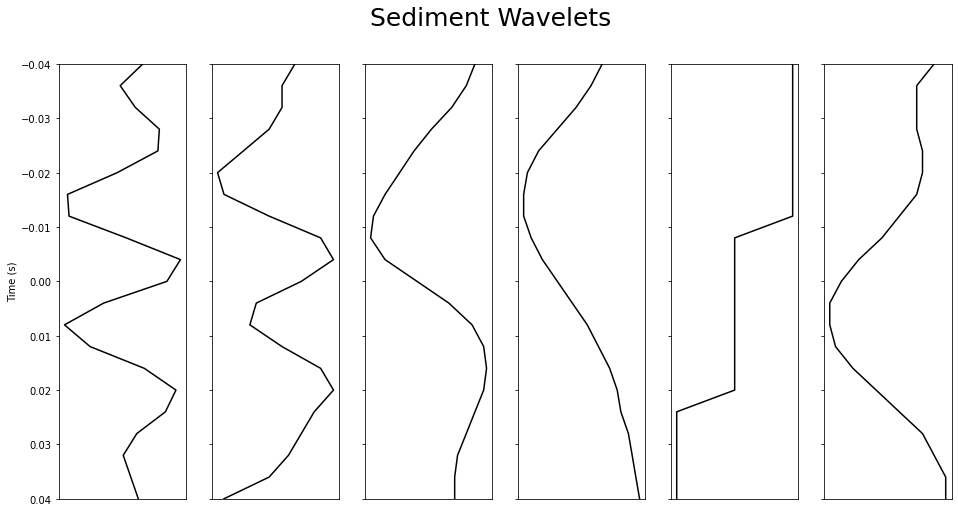

In [42]:
plot_wavelets(s_wavelets,np.arange(100,601,100),'Sediment Wavelets')

In [43]:
random.seed(2023)

all_wavelets = w_wavelets+sf_wavelets+s_wavelets
random.shuffle(all_wavelets)
data3 = np.array(all_wavelets)
data3 = data3*scale
data3.shape

(24641, 21)

In [44]:
random.seed(2023)

indicators = [0]*len(w_wavelets)+[1]*len(sf_wavelets)+[2]*len(s_wavelets)
random.shuffle(indicators)
labels3 = np.array(indicators)
labels3.shape

(24641,)

To be able to classify data into multiple classes, we can represent our labels as arrays with three elements that correspond to the probabilites of the three possible outcomes.

In [45]:
labels3 = keras.utils.to_categorical(labels3)
labels3.shape

(24641, 3)

In [46]:
labels3

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In the model definition, we will need to change the size of the output layer and the output activation function.

In [47]:
model3 = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax'),
    ]
)

In [48]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 176       
                                                                 
 dense_5 (Dense)             (None, 3)                 27        
                                                                 
Total params: 203
Trainable params: 203
Non-trainable params: 0
_________________________________________________________________


The model is now
$$\mathbf{y} = s_3\left(\mathbf{a}_2 + \mathbf{B}_2^{T}\,r\left(\mathbf{a}_1 + \mathbf{B}_1^{T}\,\mathbf{x}\right)\right)\;,$$

where $\mathbf{a}_2$ is a three-dimensional vector, $\mathbf{B}_2$ is an $8 \times 3$ matrix, and $s_3(z)$ is the *softmax* function:
$$s_3(\mathbf{z}) = \displaystyle \frac{1}{e^{z_1}+e^{z_2}+e^{z_3}}\,\left[\begin{array}{c} e^{z_1} \\ e^{z_2} \\ e^{z^3} \end{array}\right]\;.$$

Softmax is a multidimensional analog of sigmoid. It guarantees that all elements of the output vector are in the range from 0 to 1 and sum up to 1, thus approximating probabilities.

In [49]:
(8*21+8)+(3*8+3)

203

In [50]:
model3.compile(loss='categorical_crossentropy',
               optimizer=keras.optimizers.Adam(0.001), 
               metrics=['accuracy'])

<span style="color:red">Complete model training and testing.</span> 

In [51]:
# fit the model
batch_size=10
epochs=15
fit = model3.fit(data3,labels3,
                batch_size=batch_size,
                epochs=epochs,
                #class_weight=class_weights,
                validation_split=0.3)

Epoch 1/15
1725/1725 [==============================] - 4s 2ms/step - loss: 0.5661 - accuracy: 0.7917 - val_loss: 0.4340 - val_accuracy: 0.8133
Epoch 2/15
1725/1725 [==============================] - 3s 2ms/step - loss: 0.3486 - accuracy: 0.8109 - val_loss: 0.2620 - val_accuracy: 0.8131
Epoch 3/15
1725/1725 [==============================] - 3s 2ms/step - loss: 0.2134 - accuracy: 0.9541 - val_loss: 0.1668 - val_accuracy: 0.9711
Epoch 4/15
1725/1725 [==============================] - 3s 2ms/step - loss: 0.1467 - accuracy: 0.9662 - val_loss: 0.1249 - val_accuracy: 0.9702
Epoch 5/15
1725/1725 [==============================] - 3s 2ms/step - loss: 0.1137 - accuracy: 0.9677 - val_loss: 0.1007 - val_accuracy: 0.9688
Epoch 6/15
1725/1725 [==============================] - 3s 2ms/step - loss: 0.0932 - accuracy: 0.9707 - val_loss: 0.0838 - val_accuracy: 0.9752
Epoch 7/15
1725/1725 [==============================] - 3s 2ms/step - loss: 0.0789 - accuracy: 0.9754 - val_loss: 0.0716 - val_accuracy:

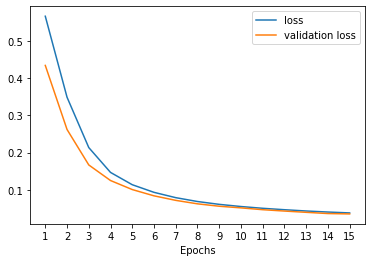

In [52]:
plot_loss(fit, epochs)

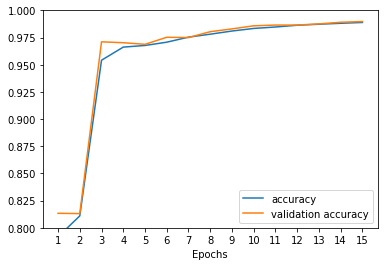

In [53]:
plot_accuracy(fit,epochs)

In [54]:
# predicting probabilities
pred = model3.predict(data)
print(pred)

207/207 [==============================] - 0s 1ms/step
[[1.0758563e-36 6.2121588e-28 9.9999994e-01]
 [1.6981601e-10 2.6023622e-10 9.9999994e-01]
 [9.5359326e-07 8.4447627e-10 9.9999899e-01]
 ...
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [6.3835892e-35 6.9439569e-19 1.0000000e+00]
 [4.3117930e-29 3.0667331e-23 1.0000000e+00]]


In [55]:
false = np.nonzero(np.rint(pred[:,0]) != labels)
print(false)

(array([   6,    8,   11, ..., 6602, 6603, 6604]),)


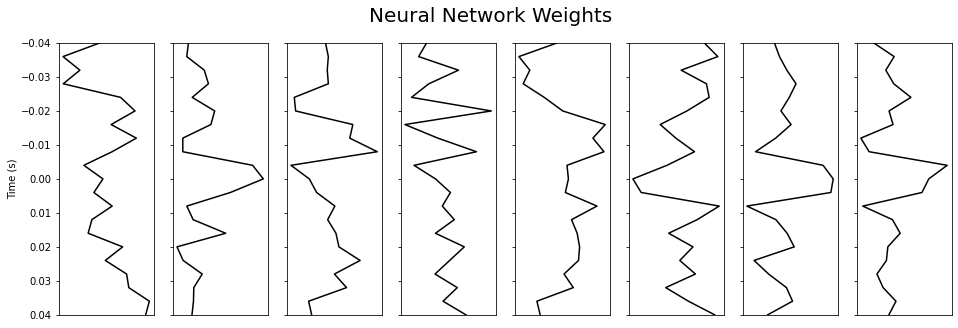

In [56]:
f, ax = plt.subplots(nrows=1,ncols=8,figsize=(16,5))
twt = np.arange(-nw//2+1,nw//2+1)*dt
for trace in range(8):
    axt = ax[trace]
    # plot as curve
    amp=weights[:,trace]
    axt.plot(amp,twt,'k')
    axt.set_ylim(twt.max(),twt.min())
    if trace == 0:
        axt.set_ylabel('Time (s)')
    else:
        axt.set_yticklabels([])
    axt.set_xticks([])
f.suptitle('Neural Network Weights',fontsize=20)
plt.show()

In [59]:
from scipy.signal import find_peaks

section = read_slice(800)[:1001, :]

pick = np.zeros(ntraces)
for k in range(ntraces):
    trace = section[:, k]
    # find local maxima
    peaks, _ = find_peaks(np.abs(trace))
    test_wavelets = []
    for peak in peaks:
        if peak > nw and peak < 1001-nw:
            wavelet = trace[peak-nw//2:peak+nw//2+1]
            test_wavelets.append(wavelet)
    # normalize
    test_wavelets = np.array(test_wavelets)*scale
    # get probabilities
    pred = model2.predict(test_wavelets)
    # select the highest probability
    best = np.argmax(pred)
    pick[k] = peaks[best]

6/6 [==============================] - 0s 2ms/step


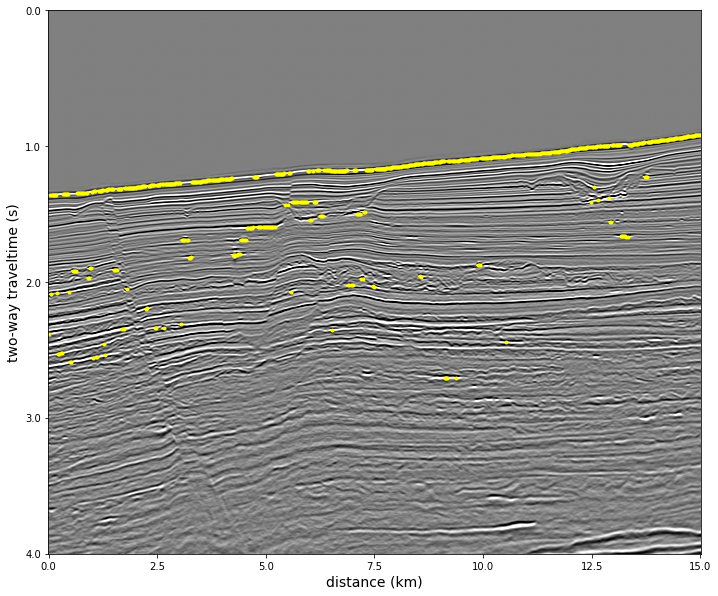

In [60]:
plt.figure(figsize=(15, 10))
plot_seismic(section)
plt.plot(pick, color='yellow', marker='.', linestyle='None')
plt.show()